In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import random
import csv
import time
from datetime import datetime, timedelta

In [2]:
API_KEY = '3GYWVXBDLL9ZQYB3F5MR3WRXN'
latitude = 12.864809173992965  # Example: Bangalore
longitude = 77.44030655982164  # Example: Bangalore

# Function to fetch weather data from Visual Crossing API
def get_weather_data(date, latitude, longitude):
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{latitude},{longitude}/{date}/{date}?unitGroup=metric&key={API_KEY}&include=obs"

    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if 'days' in data and len(data['days']) > 0:
            day_data = data['days'][0]
            temperature = day_data.get('temp', None)
            humidity = day_data.get('humidity', None)
            precipitation = day_data.get('precip', None)
            return temperature, humidity, precipitation
    else:
        print(f"Failed to get data for {date}: {response.status_code}")
        return None, None, None

# Generate sample weather data for the last 100 days
def create_sample_data():
    data = []
    end_date = datetime.now()
    start_date = end_date - timedelta(days=100)

    # Load the first 100 rows from the CSV file
    soil_data = pd.read_csv('soil.csv', header=None)
    soil_data_first_100 = soil_data[0].head(100).astype(float).tolist()

    current_date = start_date
    index = 0

    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        temperature, humidity, precipitation = get_weather_data(date_str, latitude, longitude)

        soil_humidity = soil_data_first_100[index] if index < len(soil_data_first_100) else None
        irrigation_needed = is_irrigation_needed(soil_humidity, temperature)

        data.append([date_str, temperature, humidity, precipitation, soil_humidity, irrigation_needed])

        current_date += timedelta(days=1)
        index += 1

    columns = ['Date', 'Temperature', 'Humidity', 'Precipitation', 'Soil_Humidity', 'Irrigation_Needed']
    df = pd.DataFrame(data, columns=columns)

    return df

# Simple heuristic to determine if irrigation is needed
def is_irrigation_needed(soil_humidity, temperature):
    if soil_humidity is not None and soil_humidity >400 and temperature > 25:
        return 1  # Irrigation needed
    else:
        return 0  # No irrigation needed

# Generate the sample data
sample_df = create_sample_data()

# Display the first few rows of the DataFrame
print(sample_df.head())


         Date  Temperature  Humidity  Precipitation  Soil_Humidity  \
0  2024-06-19         25.8      77.1            0.0          475.0   
1  2024-06-20         24.8      79.3           14.0          477.0   
2  2024-06-21         24.5      81.8            0.0          478.0   
3  2024-06-22         24.9      78.9            0.0          477.0   
4  2024-06-23         24.9      79.5            0.0          479.0   

   Irrigation_Needed  
0                  1  
1                  0  
2                  0  
3                  0  
4                  0  


In [3]:
# Save the DataFrame to a CSV file
#sample_df.to_csv('sample_data.csv', index=False)
#print("Sample data saved to 'sample_data.csv'")

In [4]:
# Load the dataset
data = sample_df
df = data.drop('Date',axis=1)
df = df.dropna()
df

,Temperature,Humidity,Precipitation,Soil_Humidity,Irrigation_Needed
0,25.8,77.1,0.0,475.0,1
1,24.8,79.3,14.0,477.0,0
2,24.5,81.8,0.0,478.0,0
3,24.9,78.9,0.0,477.0,0
4,24.9,79.5,0.0,479.0,0
...,...,...,...,...,...
92,25.2,69.1,2.0,17.0,0
93,25.4,69.3,0.0,168.0,0
94,24.9,75.4,0.4,169.0,0
95,24.8,78.6,0.1,170.0,0


In [5]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Temperature', 'Humidity', 'Precipitation', 'Soil_Humidity', 'Irrigation_Needed']])
scaled_data
X = scaled_data
y = df['Irrigation_Needed'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

<Figure size 1600x1200 with 0 Axes>

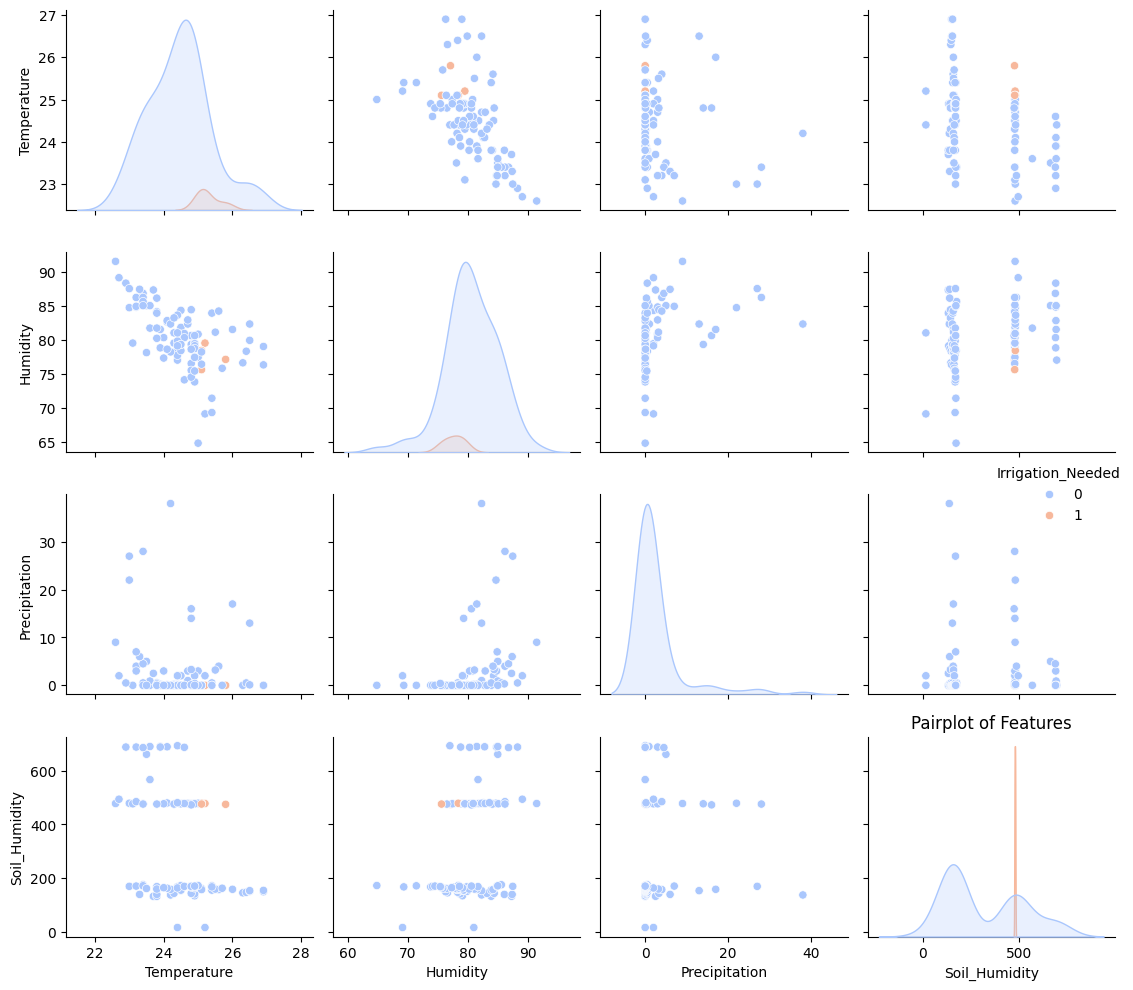

In [6]:
plt.figure(figsize=(16, 12))
sns.pairplot(df, hue='Irrigation_Needed', palette='coolwarm')
plt.title('Pairplot of Features')

plt.tight_layout()
plt.show()

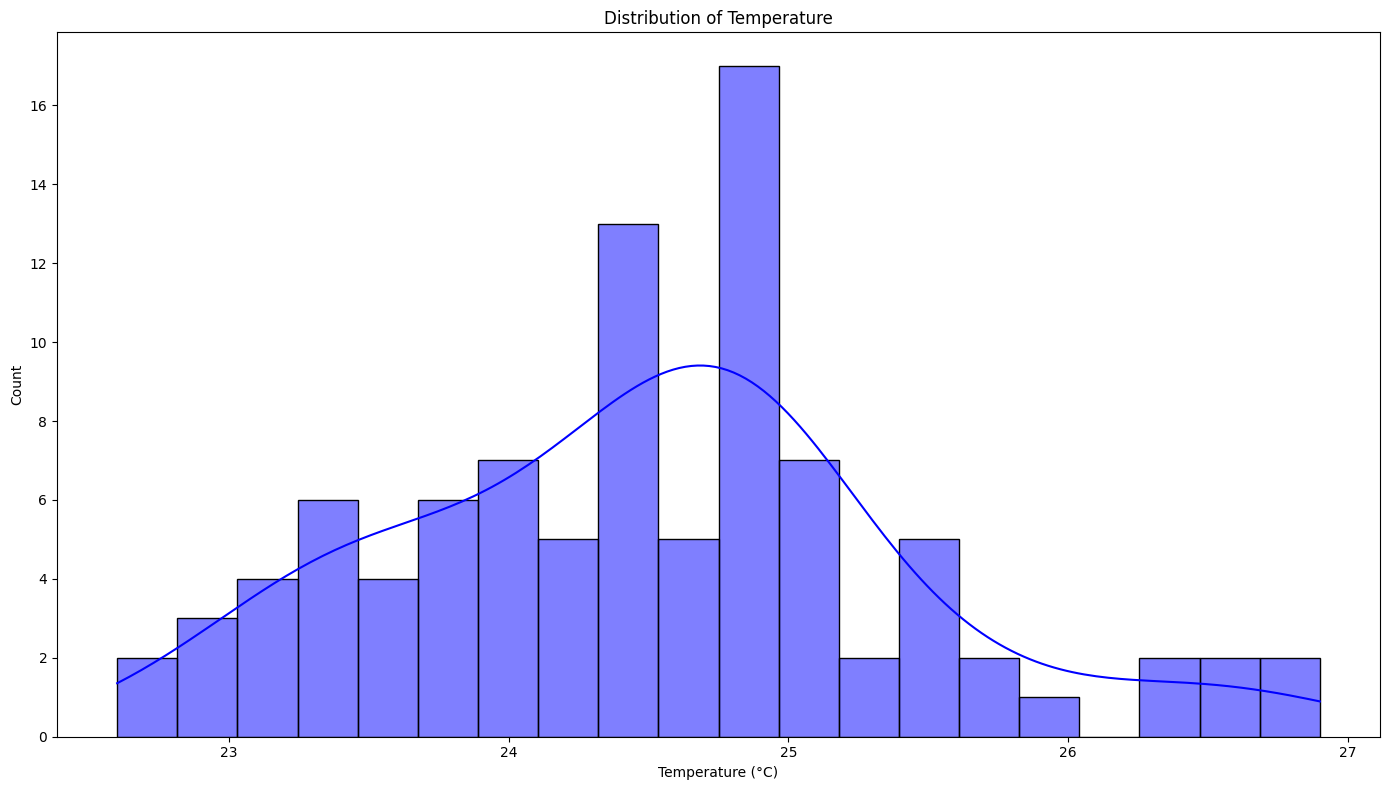

In [7]:
plt.figure(figsize=(14,8))
sns.histplot(df['Temperature'], bins=20, kde=True, color='blue')
plt.title('Distribution of Temperature')
plt.xlabel('Temperature (°C)')

plt.tight_layout()
plt.show()

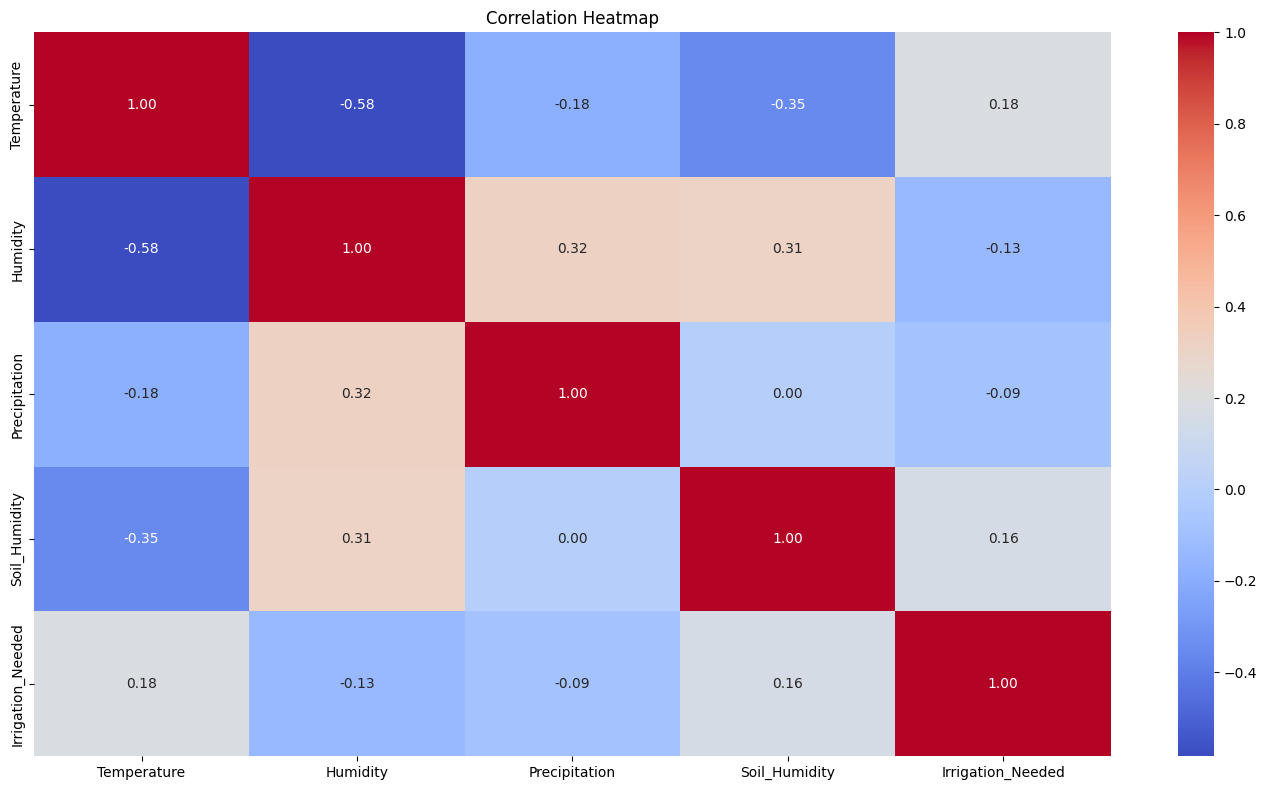

In [8]:
plt.figure(figsize=(14,8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

C:\Users\Oswin\AppData\Local\Temp\ipykernel_3796\1665586777.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Irrigation_Needed', y='Soil_Humidity', data=df, palette='coolwarm')


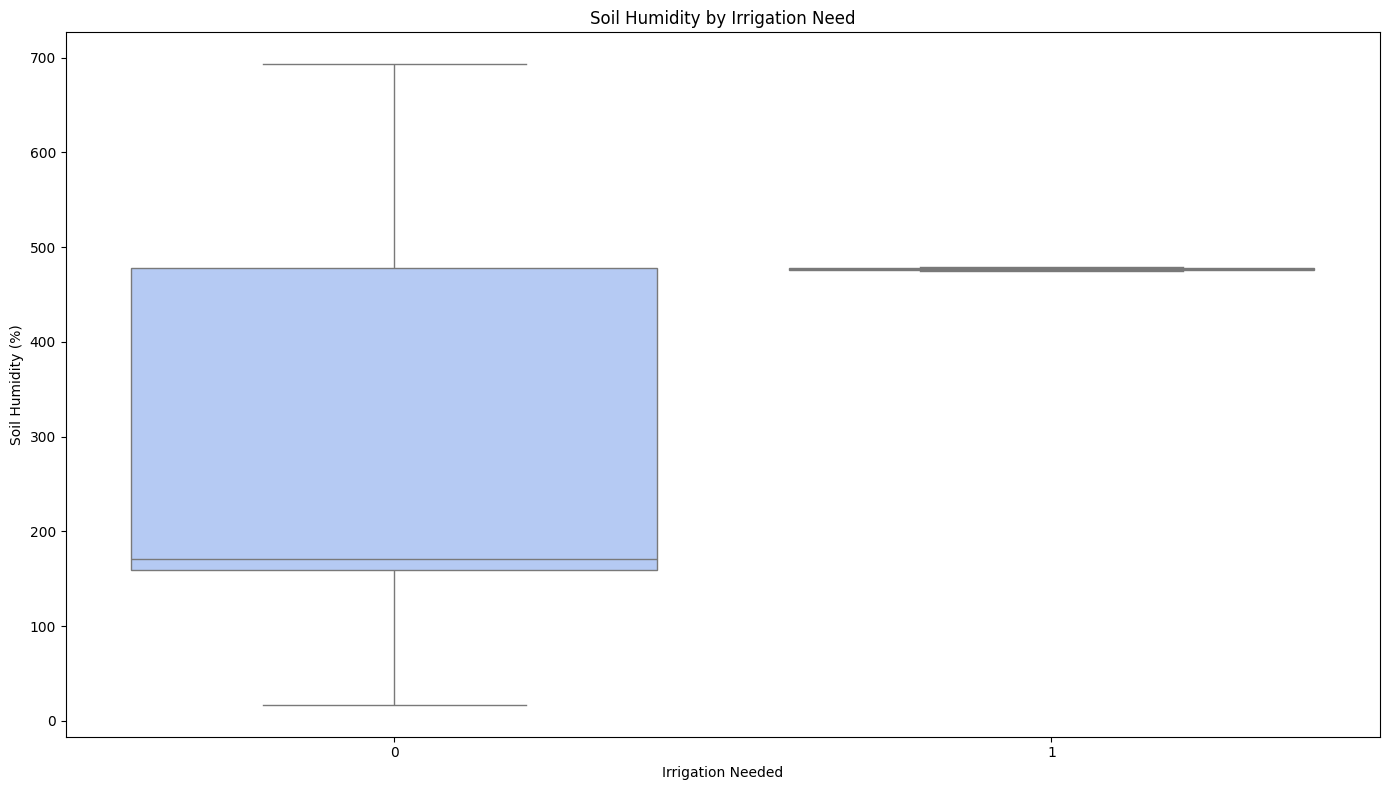

In [9]:
plt.figure(figsize=(14,8))
sns.boxplot(x='Irrigation_Needed', y='Soil_Humidity', data=df, palette='coolwarm')
plt.title('Soil Humidity by Irrigation Need')
plt.xlabel('Irrigation Needed')
plt.ylabel('Soil Humidity (%)')

plt.tight_layout()
plt.show()

In [10]:
# Define the model
model = Sequential()
model.add(LSTM(25, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

c:\Users\Oswin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 25)          │         2,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,951 (70.12 KB)

 Trainable params: 17,951 (70.12 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [14]:
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_val_reshaped, y_val))

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9895 - loss: 0.6870 - val_accuracy: 0.8421 - val_loss: 0.6759
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9817 - loss: 0.6632 - val_accuracy: 0.8421 - val_loss: 0.6593
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9895 - loss: 0.6379 - val_accuracy: 0.8421 - val_loss: 0.6416
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9934 - loss: 0.6116 - val_accuracy: 0.8421 - val_loss: 0.6219
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9934 - loss: 0.5805 - val_accuracy: 0.8421 - val_loss: 0.5996
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9895 - loss: 0.5419 - val_accuracy: 0.8421 - val_loss: 0.5738
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9895 - loss: 0.4959 - val_accuracy: 0.8421 - val_loss: 0.5447
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9817 - loss: 0.4464 - val_accuracy: 0.8421 - val_loss

In [15]:
val_loss, val_accuracy = model.evaluate(X_val_reshaped, y_val)
print(f'Validation Accuracy: {val_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8421 - loss: 0.7547
Validation Accuracy: 0.8421052694320679
